CODE BLOCK: 1

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from lib.models import Model3
from lib.utils import model_summary
from lib.utils import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

CODE BLOCK: 2

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [4]:
SEED = 1
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

CODE BLOCK: 3

In [5]:
# simple transform
simple_transforms = transforms.Compose([
                                     transforms.ToTensor(), 
                                      ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\Users\abhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-15, 15)),  # Apply random rotation between -15 and 15 degrees
        transforms.RandomAffine(degrees=0, shear=(-10, 10)),  # Apply random shear between -10 and 10 degrees
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [8]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

CODE BLOCK: 6

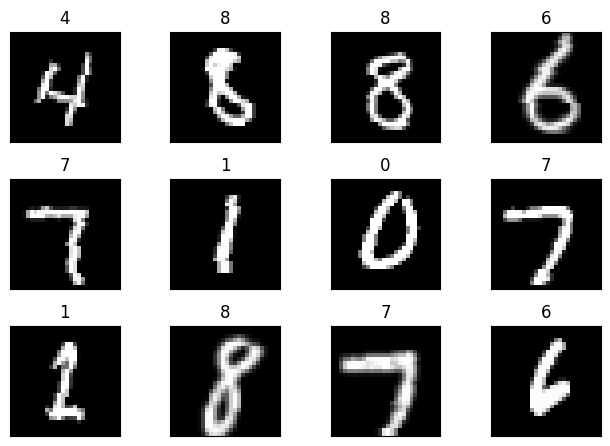

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [10]:
model_summary(Model3())


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
      BatchNorm2d-10            [-1, 8, 24, 24]              16
             ReLU-11            [-1, 8, 24, 24]               0
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

CODE BLOCK: 8

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = Model3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test_acc = test(model, device, test_loader, criterion)
  for param_group in optimizer.param_groups:
    print(f'Learning rate: {param_group["lr"]}')
  scheduler.step(test_acc)


C:\Users\abhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss=0.1180 Batch_id=468 Accuracy=85.46: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]


Test set: Average loss: 0.0897, Accuracy: 9772/10000 (97.72%)

Learning rate: 0.01
Epoch 2


Train: Loss=0.1024 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:08<00:00, 54.74it/s] 


Test set: Average loss: 0.0444, Accuracy: 9872/10000 (98.72%)

Learning rate: 0.01
Epoch 3


Train: Loss=0.1511 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:08<00:00, 52.32it/s] 


Test set: Average loss: 0.0376, Accuracy: 9895/10000 (98.95%)

Learning rate: 0.01
Epoch 4


Train: Loss=0.0569 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:08<00:00, 52.29it/s] 


Test set: Average loss: 0.0397, Accuracy: 9880/10000 (98.80%)

Learning rate: 0.01
Epoch 5


Train: Loss=0.1473 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:09<00:00, 49.67it/s]


Test set: Average loss: 0.0331, Accuracy: 9904/10000 (99.04%)

Learning rate: 0.01
Epoch 6


Train: Loss=0.0387 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:09<00:00, 50.59it/s] 


Test set: Average loss: 0.0345, Accuracy: 9895/10000 (98.95%)

Learning rate: 0.01
Epoch 7


Train: Loss=0.0580 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 49.11it/s]


Test set: Average loss: 0.0246, Accuracy: 9932/10000 (99.32%)

Learning rate: 0.01
Epoch 8


Train: Loss=0.0352 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s]


Test set: Average loss: 0.0244, Accuracy: 9932/10000 (99.32%)

Learning rate: 0.01
Epoch 9


Train: Loss=0.0322 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:12<00:00, 37.12it/s]


Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)

Learning rate: 0.01
Epoch 10


Train: Loss=0.0225 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

Learning rate: 0.005
Epoch 11


Train: Loss=0.0505 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]


Test set: Average loss: 0.0212, Accuracy: 9942/10000 (99.42%)

Learning rate: 0.005
Epoch 12


Train: Loss=0.0281 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

Learning rate: 0.005
Epoch 13


Train: Loss=0.0649 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Learning rate: 0.0025
Epoch 14


Train: Loss=0.0403 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Learning rate: 0.0025
Epoch 15


Train: Loss=0.0424 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

Learning rate: 0.0025


CODE BLOCK: 9

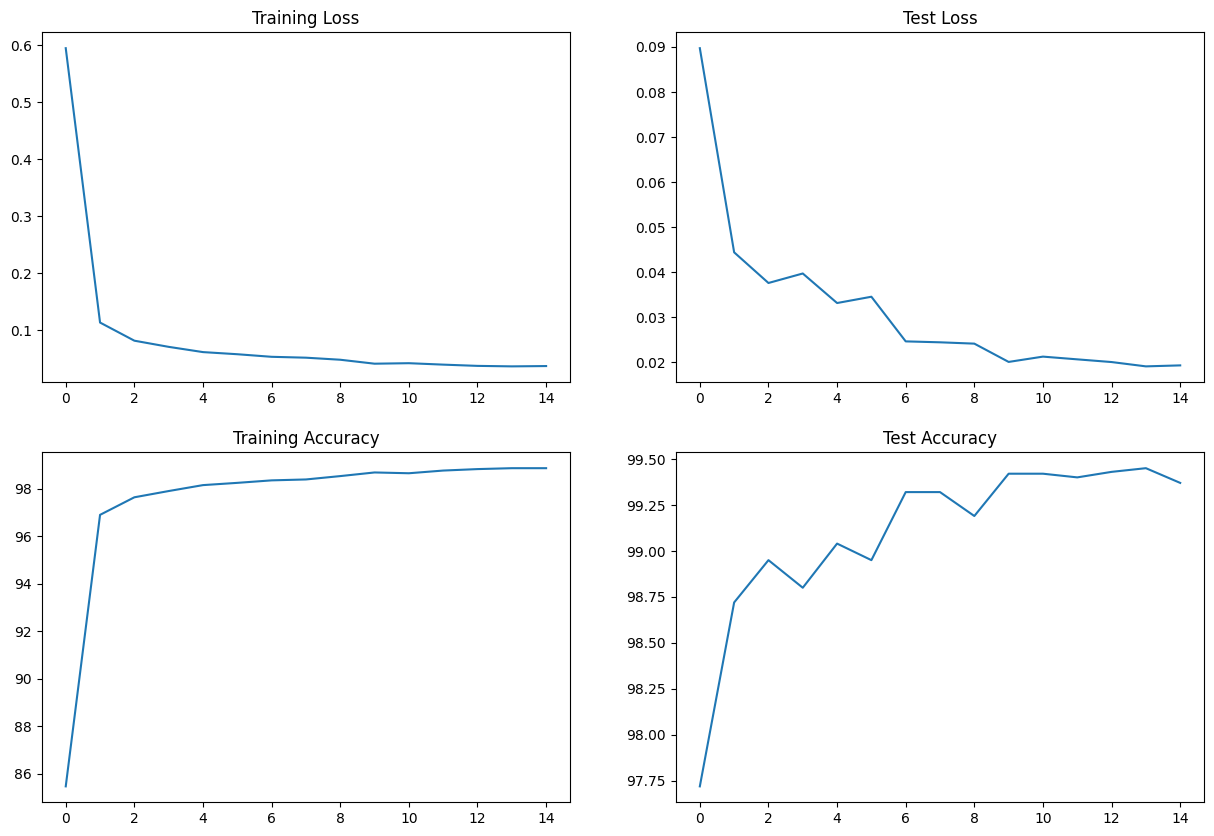

In [14]:
from lib.utils import plot_training
plot_training()

In [13]:
model_summary(Model3())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
      BatchNorm2d-10            [-1, 8, 24, 24]              16
             ReLU-11            [-1, 8, 24, 24]               0
          Dropout-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,